# DL-ESP-002-NOV22: Proyecto Final

Esta actividad es obligatoria y se evaluará como parte de la calificación final. Debe realizarse de manera individual. Antes de empezar, lea el contenido del módulo.  

Instrucciones: En esta actividad, deberá crear un modelo de deep learning. Para ello, deberá aplicar un algoritmo o un conjunto de algoritmos a un conjunto de datos para resolver un problema relacionado con el mundo empresarial. 


En el módulo 4, implementamos por primera vez nuestra propia CNN profunda para clasificar imágenes del conjunto de datos MNIST. Aprendimos que, gracias a las capas convolucionales, podíamos mejorar el rendimiento en comparación con una red estándar.

Aunque obtuvimos un buen rendimiento con MNIST, este `conjunto de datos no es muy representativo del tipo de problemas de visión artificial que quizás tengamos que resolver. Un conjunto muy popular y mucho más representativo de objetos reales es [ImageNet](https://www.image-net.org/), que contiene imágenes etiquetadas de miles de clases diferentes.

Dado que ImageNet contiene tantas clases de imágenes, la CNN simple que creamos en el módulo anterior no puede realizar las tareas de clasificación correctamente. Además, debido a sus enormes dimensiones, entrenar el modelo con el conjunto completo consumiría recursos ingentes de computación.

Afortunadamente, PyTorch incluye grandes modelos integrados que ya han sido entrenados con el conjunto de ImageNet u otros de dimensiones similares. Aprovecharemos los atributos aprendidos con estos conjuntos y usaremos los modelos preentrenados para completar nuestra propia tarea de clasificación de imágenes.

Utilizar una red preentrenada para realizar una tarea diferente con un conjunto de datos es lo que se conoce como *transfer learning*. En este cuaderno, veremos un ejemplo de esta técnica.

Nota: Entrenar estos modelos puede requerir una cantidad de tiempo considerable. Nuestro equipo ya ha ejecutado estos cuadernos y ha incluido el *output* para que pueda examinarlo y no necesite volver a entrenarlo. Sin embargo, si quiere ejecutar celdas que aparezcan más adelante en el cuaderno, deberá utilizar las anteriores. Aunque el *output* se mantiene, el estado interno del programa no.

## Selección del modelo

PyTorch incluye muchos modelos preentrenados. Puede encontrar la lista completa de los relacionados con herramientas de visión artificial [aquí](https://pytorch.org/vision/0.8/models.html), en la documentación de PyTorch. 

Para esta tarea, seleccionaremos un modelo que se utiliza para la clasificación de imágenes. El *transfer learning*, sin embargo, puede aplicarse a muchos problemas, y no está limitado a la clasificación de imágenes.

Para completar la tarea de este cuaderno, hemos elegido la red VGG11. Esta red apareció por primera vez en el artículo "Very Deep Convolutional Networks for Large-Scale Image Recognition" de Karen Simonyan y Andrew Zisserman. Puede consultarlo [aquí](https://arxiv.org/abs/1409.1556)

En el módulo, vimos ejemplos centrados en VGG16, un modelo muy similar que procede también del artículo de Simonyan y Zisserman. Para este ejemplo, hemos elegido VGG11 porque es una red ligeramente más pequeña (tiene 11 capas convolucionales en vez de 16) y requiere tiempos de entrenamiento más breves. No obstante, demuestra la potencia del *transfer learning* igual que VGG16.

In [143]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# Importa un modelo VGG11 preentrenado con ImageNet
vit_b16 = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1, progress=True)

print("model:", vit_b16)

device: cuda
model: VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=T

Vemos que la red VGG11 es gigantesca, por lo que entrenarla con ImageNet requeriría muchísimo tiempo.

Por suerte, podemos importar la red preentrenada completa con solo una línea de Python.

Ahora que tenemos una red totalmente entrenada, podemos aumentar el conjunto de datos para que sea compatible con la arquitectura y después afinarlo para adaptar VGG11 a la nueva tarea.

## Conjunto de datos

Como conjunto, hemos elegido GTSRB, un conjunto de reconocimiento de señales de tráfico alemanas (https://benchmark.ini.rub.de/gtsrb_news.html). Este conjunto es fácilmente accesible a través de PyTorch (igual que MNIST y FashionMNIST) y contiene casi 40.000 imágenes clasificadas en más de 40 clases.

Para nuestra tarea específica de *transfer learning*, vamos a clasificar este conjunto de datos.

In [144]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import InterpolationMode

inference_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224,224], interpolation=InterpolationMode.BICUBIC),
    # transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # transforms.Normalize([0], [1])
])

# Load the dataset from the root folder with the specified transforms
lemon_dataset = ImageFolder('lemon_dataset', transform=inference_transforms)

In [145]:
# Dividimos el conjunto de datos en entrenamiento y validación

# Define the sizes of each split (70% train, 15% validation, 15% test)
train_size = int(0.7 * len(lemon_dataset))
val_size = int(0.15 * len(lemon_dataset))
test_size = len(lemon_dataset) - train_size - val_size

generator=torch.Generator().manual_seed(42)

# Use random_split() to split the dataset into train, validation, and test sets
train_set, val_set, test_set = torch.utils.data.random_split(lemon_dataset, [train_size, val_size, test_size], generator=generator)

In [146]:


# Creamos DataLoaders igual que antes con un tamaño de lotes de 100
batch_size = 100
dataloaders = {'train': DataLoader(train_set, batch_size=batch_size),
               'val': DataLoader(val_set, batch_size=batch_size),
               'test': DataLoader(test_set, batch_size=batch_size)}

dataset_sizes = {'train': len(train_set),
                 'val': len(val_set),
                 'test': len(test_set)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1769, 'val': 379, 'test': 380}


In [147]:
# Primero, definir el número total de clases:
lemon_labels = set()
for _, labels in dataloaders["val"]:
    for label in labels:
        lemon_labels.add(label.item())
print(len(lemon_labels))
print(lemon_labels)
        

3
{0, 1, 2}


## Visualización

Ahora, visualizaremos el conjunto de datos para ver algunas de las imágenes y clases con las que estamos trabajando.

In [22]:
# Trazar una ground truth sobre las cifras y autocodificar

def view_lemon(tensor):
    tensor = tensor.cpu().detach().permute((1,2,0))
    plt.imshow(tensor)

def view_lemon_class(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # Solo queremos ver una clase determinada
            if (labels[i] != label):
                continue
            # Trazar la ground truth
            ax = fig.add_subplot(1, count, idx)

            view_lemon(input)
            
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

def view_lemon_all():
    for i in range(3):
        view_lemon_class(i)

In [157]:
dataloaders["train"].dataset[3][1]

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


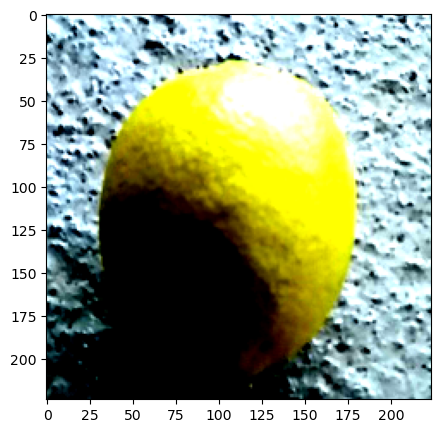

In [154]:
fig = plt.figure(figsize=(5,5))

idx = 5
niceLemon = dataloaders["train"].dataset[idx][0].unsqueeze(0)
someLemon1 = dataloaders["train"].dataset[502][0].unsqueeze(0)
someLemon2 = dataloaders["test"].dataset[22][0].unsqueeze(0)
someLemon3 = dataloaders["val"].dataset[52][0].unsqueeze(0)

view_lemon(niceLemon.squeeze(0))

out = torch.softmax(vit_b16.forward(niceLemon), dim=1)

# view_lemon(someLemon.squeeze(0))

In [134]:
sorted_out, indices = torch.sort(out[0], descending=True)

# Print the top 10 values and their indices
for i in range(10):
    print(f"{i+1}: Value {sorted_out[i]}, Index {indices[i]}")

1: Value 0.9775465130805969, Index 951
2: Value 0.01734345220029354, Index 950
3: Value 0.0015269021969288588, Index 522
4: Value 0.0008759180782362819, Index 940
5: Value 0.00015747809084132314, Index 722
6: Value 8.81408850545995e-05, Index 955
7: Value 5.245488864602521e-05, Index 852
8: Value 5.104506999487057e-05, Index 308
9: Value 4.578715015668422e-05, Index 952
10: Value 4.289441494620405e-05, Index 738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


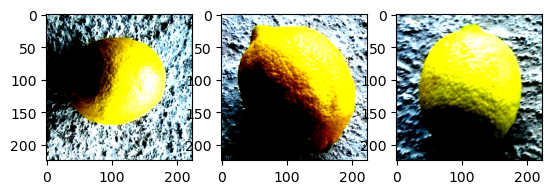

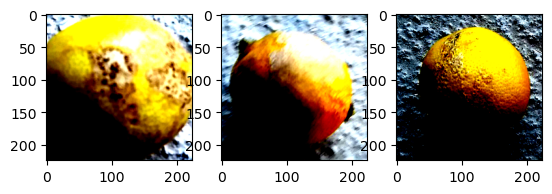

In [135]:
view_lemon_class(2, 3)
view_lemon_class(0, 3)


## Aumentar el modelo

Ahora que hemos investigado el conjunto de datos, queremos modificar la arquitectura de VGG11 original para poder clasificar correctamente las imágenes. Durante la fase de importación de datos, reajustamos el tamaño de las imágenes de *input* a las dimensiones correctas 224 x 224 x 3, para que VGG11 pueda manejar el *input*. Sin embargo, en la arquitectura VGG11 original, la capa de *output* tenía un tamaño de 1000, por lo que no coincide con las 43 clases de señales de tráfico. Para resolver esto, es necesario eliminar la última capa y sustituirla por una capa de tamaño 43.

In [158]:
# Congelar los pesos de la red
for param in vit_b16.parameters():
    param.requires_grad = False
# Cambiar la última capa para que contenga tantos outputs como clases hay en el conjunto de datos
# Por defecto, los pesos de las nuevas capas no están congelados

vit_b16.heads.head  = nn.Linear(vit_b16.heads.head.in_features, len(lemon_labels))
vit_b16 = vit_b16.to(device)

# ACA  .  ACA  .  ACA  .  ACA  .  ACA  .  ACA  .  ACA

## Quiza haya que implementar Softmax al final

## Entrenar el modelo

Al utilizar *transfer learning*, dividimos el proceso de entrenamiento en dos fases.

Primero, vamos a congelar los pesos de la red preentrenada para centrarnos en afinar solo la última capa de clasificación. Cuando ese entrenamiento haya convergido, descongelaremos toda la red profunda y pasaremos a la segunda fase de entrenamiento. Se ha demostrado que dividir el entrenamiento de esta manera permite que el modelo alcance un rendimiento óptimo y que en el módulo principal se encuentre más información relativa al razonamiento.

In [159]:
# Extraído de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Almacenar los mejores pesos por separado
    best_acc = 0.0
    best_epoch = 0

   # Cada ciclo tiene una fase de entrenamiento, validación y prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en modo de evaluación
                
            running_loss = 0.0
            running_corrects = 0

           # Iterar con los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a cero los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Hacer una copia profunda del modelo si ha alcanzado la mayor precisión
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves


### Fase 1

Ahora, comenzaremos la fase de entrenamiento 1. En esta fase, se congelan los pesos de todas las capas, salvo los de la última. Eso nos permite utilizar la red preentrenada como "extractor de atributos" y, después, afinar la última capa de clasificación para la tarea que queremos completar. Realizaremos 10 ciclos de entrenamiento para reducir el tiempo, pero, para lograr el mejor rendimiento posible, debemos seguir entrenando hasta que converjan la pérdida y la precisión de la validación.

(Nota: el equipo tardó unos 25 minutos en completar este entrenamiento en una instancia de Google Colab basada en una GPU. Puede examinar los resultados sin necesidad de ejecutar el entrenamiento).

In [160]:
learning_rate = 0.001
num_epochs = 1

In [162]:
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación
optimizer = torch.optim.Adam(vit_b16.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar al modelo. También actualizaremos los resultados del entrenamiento para poder visualizarlos
vit_b16_phase1, training_curves_phase1 = train_classification_model(vit_b16, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/1
----------


KeyboardInterrupt: 

### Visualizar las curvas de entrenamiento y los resultados

In [ ]:
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en modo de evaluación
    all_labels = torch.tensor([])
    all_scores = torch.tensor([])
    all_preds = torch.tensor([])
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels.detach().cpu()), 0)
        all_scores = torch.cat((all_scores, scores.detach().cpu()), 0)
        all_preds = torch.cat((all_preds, preds.detach().cpu()), 0)
    return all_preds, all_labels, all_scores

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

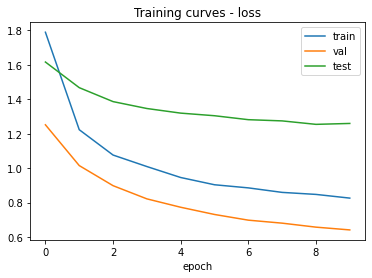

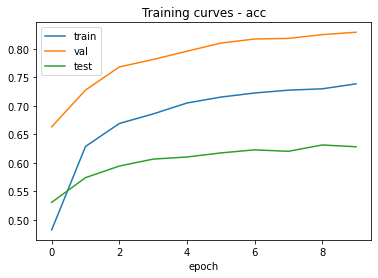

In [ ]:
plot_training_curves(training_curves_phase1, phases=['train', 'val', 'test'])

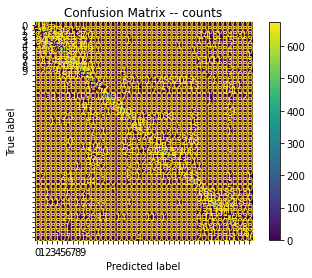

In [ ]:
# COMPLETAR: ¿Hay alguna manera de representar esta visualización con las 43 clases?
res = plot_cm(vgg11_phase1, device, dataloaders, phase='test')

### Fase 2

Ahora que hemos alcanzado un rendimiento aceptable, vamos a descongelar todos los pesos y realizar una segunda fase de entrenamiento. Afinaremos también las capas de extracción de atributos, además de la última capa de clasificación.

Una cosa que se debe tener en cuenta es que, puesto que estamos entrenando todos los pesos, esta fase del entrenamiento será considerablemente más larga que la fase 1.

In [ ]:
# Descongelar los pesos de la red
for param in vgg11_phase1.parameters():
    param.requires_grad = True


In [ ]:
# Pérdida y optmizador
criterion = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación
optimizer = torch.optim.Adam(vgg11_phase1.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar el modelo. También almacenaremos los resultados del entrenamiento para visualizarlos
vgg11_phase2, training_curves_phase2 = train_classification_model(vgg11_phase1, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 3.6039 Acc: 0.0985
val   Loss: 2.2241 Acc: 0.2976
test  Loss: 2.2732 Acc: 0.2898

Epoch 2/10
----------
train Loss: 1.4145 Acc: 0.5451
val   Loss: 0.3975 Acc: 0.8766
test  Loss: 0.6583 Acc: 0.8041

Epoch 3/10
----------
train Loss: 0.3311 Acc: 0.8946
val   Loss: 0.2049 Acc: 0.9368
test  Loss: 0.4959 Acc: 0.8834

Epoch 4/10
----------
train Loss: 0.1600 Acc: 0.9504
val   Loss: 0.1141 Acc: 0.9641
test  Loss: 0.3717 Acc: 0.8983

Epoch 5/10
----------
train Loss: 0.0920 Acc: 0.9717
val   Loss: 0.0942 Acc: 0.9706
test  Loss: 0.3554 Acc: 0.9092

Epoch 6/10
----------
train Loss: 0.0640 Acc: 0.9793
val   Loss: 0.1169 Acc: 0.9703
test  Loss: 0.4100 Acc: 0.9201

Epoch 7/10
----------
train Loss: 0.0655 Acc: 0.9806
val   Loss: 0.0492 Acc: 0.9869
test  Loss: 0.3695 Acc: 0.9325

Epoch 8/10
----------
train Loss: 0.0354 Acc: 0.9887
val   Loss: 0.0541 Acc: 0.9835
test  Loss: 0.3536 Acc: 0.9288

Epoch 9/10
----------
train Loss: 0.0424 Acc: 0.9868
val   Loss: 0.0642

### Visualizar las curvas de entrenamiento y los resultados

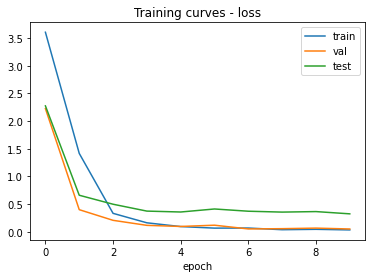

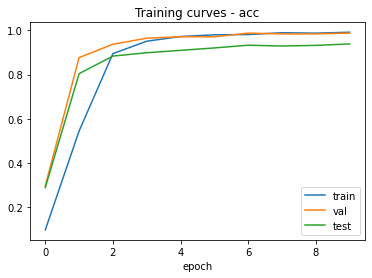

In [ ]:
plot_training_curves(training_curves_phase2, phases=['train', 'val', 'test'])

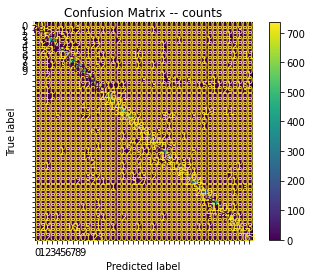

In [ ]:
res = plot_cm(vgg11, device, dataloaders, phase='test')

## ¿Qué viene ahora?

La rapidez con la que hemos alcanzado un alto rendimiento del modelo demuestra que el *transfer learning* es una herramienta muy potente. Permite obtener un buen rendimiento con conjuntos de datos nuevos en un tiempo reducido. Además, aunque en este caso, la hemos utilizado para la clasificación de imágenes, sirve para cualquier tarea de *machine learning*.

Ahora que contamos con esta herramienta, es hora de dejar atrás las CNN y los problemas relacionados con la visión artificial. En las próximas secciones, investigaremos los modelos basados en el lenguaje y el texto, y aprenderemos a utilizarlos para resolver nuevos problemas.